reading from parquet

In [5]:
import polars as pl
import os

# Path to processed data
processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Load all batches lazily (memory efficient)
df = pl.scan_parquet(f"{processed_path}/*.parquet")

# Basic counts
print("=== Basic Statistics ===")
print(f"Total records: {df.select(pl.count()).collect()[0,0]:,}")

# Unique printers
unique_printers = df.select(pl.col("id").unique()).collect()
print(f"\nUnique printers: {len(unique_printers)}")
print("\nPrinter IDs:")
for printer_id in sorted(unique_printers["id"]):
    print(f"  {printer_id}")

=== Basic Statistics ===
Total records: 94,869,699


/var/folders/n3/lvjf2dhd2xbczw56rt1rzqx80000gn/T/ipykernel_20207/3329083031.py:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  print(f"Total records: {df.select(pl.count()).collect()[0,0]:,}")



Unique printers: 8

Printer IDs:
  CZPX1522X017XC78087
  CZPX1522X017XC78307
  CZPX1622X017XC78384
  CZPX1622X017XC78456
  CZPX1622X017XC78491
  CZPX4521X017XC64043
  CZPX4721X017XC66125
  CZPX4921X017XC67390


<h3>records per printer
</h3>

In [6]:
# Records per printer
print("\nRecords per printer:")
printer_counts = (
    df.group_by("id")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

for row in printer_counts.iter_rows():
    printer_id, count = row
    percentage = (count / 94_869_699) * 100
    print(f"  {printer_id}: {count:,} ({percentage:.1f}%)")


Records per printer:
  CZPX4521X017XC64043: 13,588,541 (14.3%)
  CZPX1622X017XC78456: 13,579,643 (14.3%)
  CZPX4921X017XC67390: 13,571,114 (14.3%)
  CZPX1622X017XC78384: 13,562,963 (14.3%)
  CZPX1522X017XC78087: 13,556,040 (14.3%)
  CZPX1622X017XC78491: 13,535,509 (14.3%)
  CZPX1522X017XC78307: 11,737,619 (12.4%)
  CZPX4721X017XC66125: 1,738,270 (1.8%)


<h3>checking the date range </h3>

In [7]:
# Overall date range
date_range = df.select([
    pl.col("date").min().alias("start_date"),
    pl.col("date").max().alias("end_date")
]).collect()

print("\nOverall date range:")
print(f"  Start: {date_range['start_date'][0]}")
print(f"  End: {date_range['end_date'][0]}")

# Check date range for the low-record printer
low_printer = "CZPX4721X017XC66125"
low_printer_dates = (
    df.filter(pl.col("id") == low_printer)
    .select([
        pl.col("date").min().alias("start"),
        pl.col("date").max().alias("end")
    ])
    .collect()
)

print(f"\nDate range for {low_printer}:")
print(f"  Start: {low_printer_dates['start'][0]}")
print(f"  End: {low_printer_dates['end'][0]}")


Overall date range:
  Start: 2024-04-03T12:27:00.652Z
  End: 2025-04-29T23:00:01.363Z

Date range for CZPX4721X017XC66125:
  Start: 2025-01-29T15:08:55.254Z
  End: 2025-03-10T23:59:58.706Z


<h3>failed vs success check</h3>

In [7]:
# Check status distribution
print("\nCheck status distribution:")
check_dist = (
    df.group_by("check")
    .agg(pl.len().alias("count"))
    .collect()
)

total = 94_869_699
for row in check_dist.iter_rows():
    status, count = row
    percentage = (count / total) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

# Failed records by printer
print("\nFailed records by printer:")
failed_by_printer = (
    df.filter(pl.col("check") == "failed")
    .group_by("id")
    .agg(pl.len().alias("failed_count"))
    .sort("failed_count", descending=True)
    .collect()
)

for row in failed_by_printer.iter_rows():
    printer_id, failed = row
    print(f"  {printer_id}: {failed:,}")


Check status distribution:


AttributeError: 'DataFrame' object has no attribute 'collect'

In [1]:
import polars as pl
import os

processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Check each batch for null checks
print("Checking all batches for null 'check' values...\n")
print(f"{'Batch':<10} {'Total Records':<15} {'Null Checks':<15} {'Percentage':<10}")
print("-" * 50)

total_nulls = 0
total_records = 0
batches_with_nulls = []

# Get all batch files sorted
batch_files = sorted([f for f in os.listdir(processed_path) if f.endswith('.parquet')])

for batch_file in batch_files:
    # Read batch
    df = pl.read_parquet(f"{processed_path}/{batch_file}")
    
    # Count nulls
    null_count = df['check'].null_count()
    batch_total = len(df)
    null_pct = (null_count / batch_total * 100) if batch_total > 0 else 0
    
    # Track totals
    total_nulls += null_count
    total_records += batch_total
    
    # Print results
    batch_num = batch_file.replace('batch_', '').replace('.parquet', '')
    print(f"{batch_num:<10} {batch_total:<15,} {null_count:<15,} {null_pct:<10.2f}%")
    
    if null_count > 0:
        batches_with_nulls.append((batch_file, null_count))

print("-" * 50)
print(f"{'TOTAL':<10} {total_records:<15,} {total_nulls:<15,} {(total_nulls/total_records*100):<10.2f}%")
print(f"\nBatches with nulls: {len(batches_with_nulls)} out of {len(batch_files)}")

Checking all batches for null 'check' values...

Batch      Total Records   Null Checks     Percentage
--------------------------------------------------
001        3,331,416       0               0.00      %
002        2,805,908       0               0.00      %
003        3,005,163       0               0.00      %
004        3,005,002       0               0.00      %
005        2,223,424       0               0.00      %
006        2,292,976       0               0.00      %
007        3,004,799       0               0.00      %
008        3,004,960       0               0.00      %
009        3,005,002       0               0.00      %
010        3,005,135       0               0.00      %
011        2,150,302       0               0.00      %
012        2,230,298       0               0.00      %
013        3,004,981       0               0.00      %
014        3,004,567       0               0.00      %
015        3,005,184       0               0.00      %
016        2,673,293 

In [2]:
# Verify we're looking at the right data
import os
from datetime import datetime

processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Check file timestamps
print("Checking file creation times...\n")
print(f"{'File':<20} {'Modified Time':<25} {'Size (MB)':<10}")
print("-" * 60)

for i in range(1, 6):  # Check first 5 files
    file_path = f"{processed_path}/batch_{i:03d}.parquet"
    if os.path.exists(file_path):
        mod_time = datetime.fromtimestamp(os.path.getmtime(file_path))
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"batch_{i:03d}.parquet{' ':<5} {mod_time.strftime('%Y-%m-%d %H:%M:%S'):<25} {size_mb:<10.2f}")

# Now let's re-check the overall statistics
print("\n" + "="*60)
print("RE-CHECKING OVERALL STATISTICS WITH CLEAN DATA:")
print("="*60)

# Load all data lazily
df = pl.scan_parquet(f"{processed_path}/*.parquet")

# Check status distribution
check_dist = (
    df.group_by("check")
    .agg(pl.len().alias("count"))
    .collect()
)

print("\nCheck status distribution:")
total = 94_869_699
for row in check_dist.iter_rows():
    status, count = row
    percentage = (count / total) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

Checking file creation times...

File                 Modified Time             Size (MB) 
------------------------------------------------------------
batch_001.parquet      2025-07-29 06:55:00       20.96     
batch_002.parquet      2025-07-29 06:55:01       15.14     
batch_003.parquet      2025-07-29 06:55:03       16.11     
batch_004.parquet      2025-07-29 06:55:05       16.31     
batch_005.parquet      2025-07-29 06:55:07       10.95     

RE-CHECKING OVERALL STATISTICS WITH CLEAN DATA:

Check status distribution:
  : 2,091,429 (2.2%)
  failed: 12,176,634 (12.8%)
  success: 80,601,636 (85.0%)


In [4]:
# Check ALL batches for empty string checks
print("Checking all batches for empty string 'check' values...\n")

batches_with_empty = []
total_empty = 0

for i in range(1, 35):  # All 34 batches
    try:
        df = pl.read_parquet(f"{processed_path}/batch_{i:03d}.parquet")
        
        # Count empty strings
        empty_count = (df['check'] == '').sum()
        
        if empty_count > 0:
            batches_with_empty.append(i)
            total_empty += empty_count
            print(f"Batch {i}: {empty_count:,} empty strings found")
    except:
        print(f"Batch {i}: Error reading file")

print(f"\nTotal empty strings: {total_empty:,}")
print(f"Batches with empty strings: {batches_with_empty}")

Checking all batches for empty string 'check' values...

Batch 1: 2,091,429 empty strings found

Total empty strings: 2,091,429
Batches with empty strings: [1]


In [5]:
# Load batch 1
df = pl.read_parquet(f"{processed_path}/batch_001.parquet")

print(f"Batch 1 total records: {len(df):,}")
print(f"Empty 'check' records: {(df['check'] == '').sum():,}")

# See which printers have empty checks
empty_check_df = df.filter(pl.col('check') == '')
printers_with_empty = empty_check_df.group_by('id').agg(pl.len().alias('count'))
print("\nPrinters with empty 'check' values:")
for row in printers_with_empty.iter_rows():
    print(f"  {row[0]}: {row[1]:,} records")

# Simple fix - replace empty strings with 'success'
df = df.with_columns(
    pl.when(pl.col('check') == '')
    .then(pl.lit('success')) 
    .otherwise(pl.col('check'))
    .alias('check')
)

# Save the fixed batch
df.write_parquet(f"{processed_path}/batch_001_fixed.parquet")
print("\nFixed batch saved as batch_001_fixed.parquet")

Batch 1 total records: 3,331,416
Empty 'check' records: 2,091,429

Printers with empty 'check' values:
  CZPX1522X017XC78087: 288,739 records
  CZPX4521X017XC64043: 321,236 records
  CZPX1522X017XC78307: 301,418 records
  CZPX4921X017XC67390: 303,813 records
  CZPX1622X017XC78491: 268,213 records
  CZPX1622X017XC78456: 312,346 records
  CZPX1622X017XC78384: 295,664 records

Fixed batch saved as batch_001_fixed.parquet


In [12]:
# Use lazy loading to handle schema differences
df_lazy = pl.scan_parquet(f"{processed_path}/*.parquet")

# Get check status distribution
print("Check status distribution:")
check_dist = df_lazy.group_by("check").agg(pl.len().alias("count")).collect()

# Calculate total from the aggregated results
total_records = check_dist['count'].sum()
print(f"\nTotal records (calculated): {total_records:,}")

for row in check_dist.iter_rows():
    status, count = row
    percentage = (count / total_records) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

# Failed records by printer
print("\nFailed records by printer:")
failed_by_printer = (
    df_lazy.filter(pl.col("check") == "failed")
    .group_by("id")
    .agg(pl.len().alias("failed_count"))
    .sort("failed_count", descending=True)
    .collect()
)

for row in failed_by_printer.iter_rows():
    printer_id, failed = row
    print(f"  {printer_id}: {failed:,}")

Check status distribution:

Total records (calculated): 94,869,699
  failed: 12,176,634 (12.8%)
  success: 82,693,065 (87.2%)

Failed records by printer:
  CZPX1622X017XC78456: 2,050,330
  CZPX1622X017XC78491: 2,006,618
  CZPX1522X017XC78307: 1,764,592
  CZPX1522X017XC78087: 1,745,260
  CZPX4521X017XC64043: 1,707,279
  CZPX4921X017XC67390: 1,549,594
  CZPX1622X017XC78384: 1,352,887
  CZPX4721X017XC66125: 74


  Using cached matplotlib-3.10.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (107 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pandas-2.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached matplotlib-3.10.3-cp311-cp311-macosx_11_0_arm64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.0-cp311-cp311-macosx_10_9_universal2.whl (2.8 

/var/folders/n3/lvjf2dhd2xbczw56rt1rzqx80000gn/T/ipykernel_34589/811787928.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tusharjoshi/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


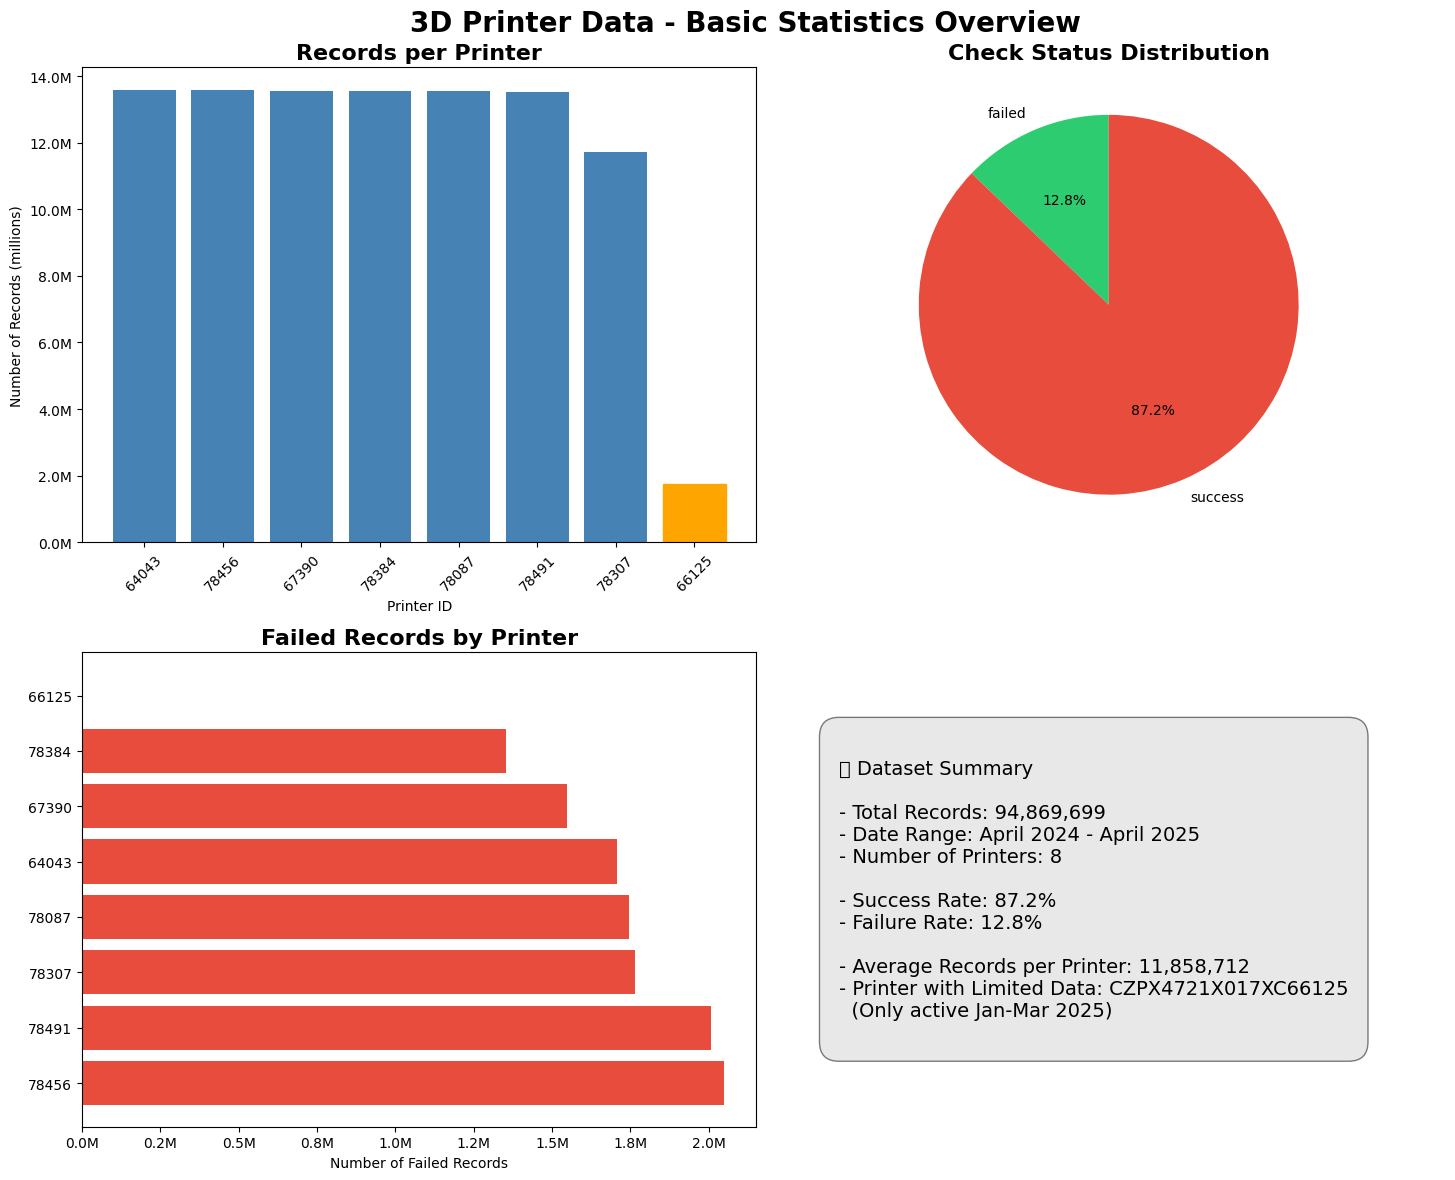

In [16]:
%pip install matplotlib seaborn


import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Records per Printer (Bar Chart)
printer_counts = df_lazy.group_by("id").agg(pl.len().alias("count")).collect().sort("count", descending=True)
bars = ax1.bar(range(len(printer_counts)), printer_counts['count'], color='steelblue')
ax1.set_xlabel('Printer ID')
ax1.set_ylabel('Number of Records (millions)')
ax1.set_title('Records per Printer', fontsize=16, fontweight='bold')
ax1.set_xticks(range(len(printer_counts)))
ax1.set_xticklabels([id[-5:] for id in printer_counts['id']], rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Highlight the printer with few records
bars[-1].set_color('orange')

# 2. Check Status Distribution (Pie Chart)
colors = ['#2ecc71', '#e74c3c']  # green for success, red for failed
ax2.pie(check_dist['count'], labels=check_dist['check'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Check Status Distribution', fontsize=16, fontweight='bold')

# 3. Failed Records by Printer (Horizontal Bar)
ax3.barh(range(len(failed_by_printer)), failed_by_printer['failed_count'], color='#e74c3c')
ax3.set_yticks(range(len(failed_by_printer)))
ax3.set_yticklabels([id[-5:] for id in failed_by_printer['id']])
ax3.set_xlabel('Number of Failed Records')
ax3.set_title('Failed Records by Printer', fontsize=16, fontweight='bold')
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# 4. Summary Statistics Text
ax4.axis('off')
summary_text = f"""
📊 Dataset Summary

- Total Records: {total_records:,}
- Date Range: April 2024 - April 2025
- Number of Printers: 8

- Success Rate: 87.2%
- Failure Rate: 12.8%

- Average Records per Printer: {total_records//8:,}
- Printer with Limited Data: CZPX4721X017XC66125
  (Only active Jan-Mar 2025)
"""
ax4.text(0.1, 0.5, summary_text, fontsize=14, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=1", facecolor="lightgray", alpha=0.5))

plt.suptitle('3D Printer Data - Basic Statistics Overview', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
if 'df' in globals():
    del df
    print("✓ Deleted df")



✓ Deleted df


we have visualised and tackled the basic eda part along with missing check values issue now we move on to further eda for which we are just going to use lazy df to handle the mismatch of data types

In [1]:
# Essential imports
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define paths
processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Load data lazily
df_lazy = pl.scan_parquet(f"{processed_path}/*.parquet")

# Define sensor fields for later use
sensor_fields = ['state', 'tempBed', 'targetBed', 'tempNozzle', 'targetNozzle', 
                'axisZ', 'axisX', 'axisY', 'flow', 'speed', 'fanHotend', 'fanPrint']

state distribution analysis

In [ ]:
# Check a single batch to understand the data
df_batch1 = pl.read_parquet(f"{processed_path}/batch_001_fixed.parquet")

# Count states in this batch
print("State values in batch 1:")
state_counts = df_batch1['state'].value_counts()
print(state_counts)

# Check for nulls
null_count = df_batch1['state'].null_count()
print(f"\nNull states: {null_count}")

State values in batch 1:
shape: (6, 2)
┌──────────┬─────────┐
│ state    ┆ count   │
│ ---      ┆ ---     │
│ str      ┆ u32     │
╞══════════╪═════════╡
│ PAUSED   ┆ 37192   │
│ PRINTING ┆ 273590  │
│ FINISHED ┆ 1623493 │
│ STOPPED  ┆ 118     │
│ IDLE     ┆ 1396422 │
│ BUSY     ┆ 601     │
└──────────┴─────────┘

Null states: 0
